In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline

import matplotlib.pyplot as plt


In [2]:
all_xray_df = pd.read_csv("D:/Xray_Data/data/images/Data_Entry_2017.csv")
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('D:','Xray_Data', 'data', 'images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
81138,00019924_030.png,Cardiomegaly|Edema|Effusion|Mass|Nodule,30,19924,56,F,AP,3056,2544,0.139,0.139,NaN,D:Xray_Data\data\images_2\00019924_030.png
17569,00004738_002.png,Mass,2,4738,66,F,PA,2048,2500,0.171,0.171,NaN,D:Xray_Data\data\images_2\00004738_002.png
84894,00020925_000.png,Infiltration,0,20925,32,F,PA,2650,2417,0.143,0.143,NaN,D:Xray_Data\data\images_2\00020925_000.png


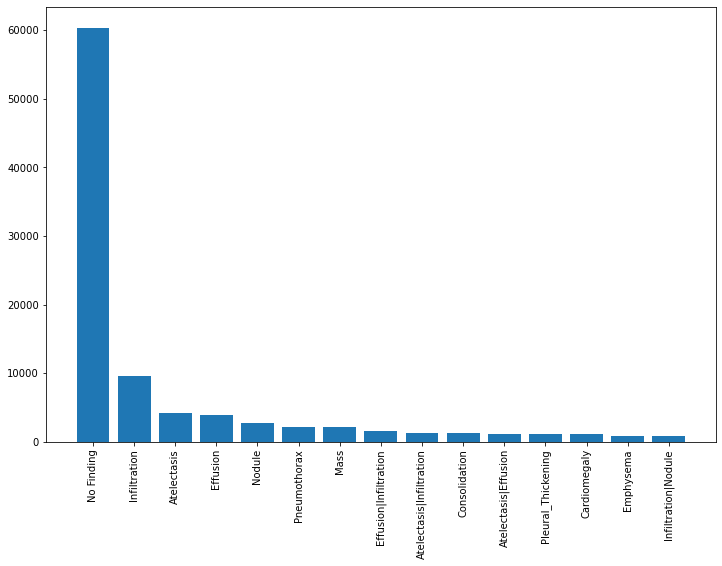

In [3]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [4]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)


All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
75639,00018561_001.png,Infiltration,1,18561,50,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
80523,00019770_004.png,Infiltration,4,19770,52,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8364,00002218_002.png,Effusion|Pleural_Thickening|Pneumothorax,2,2218,54,F,PA,2048,2500,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [5]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

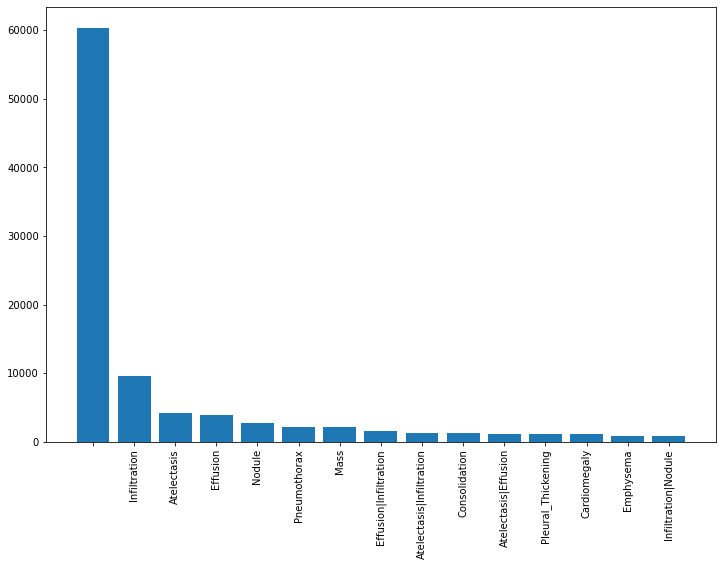

In [6]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(112120, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

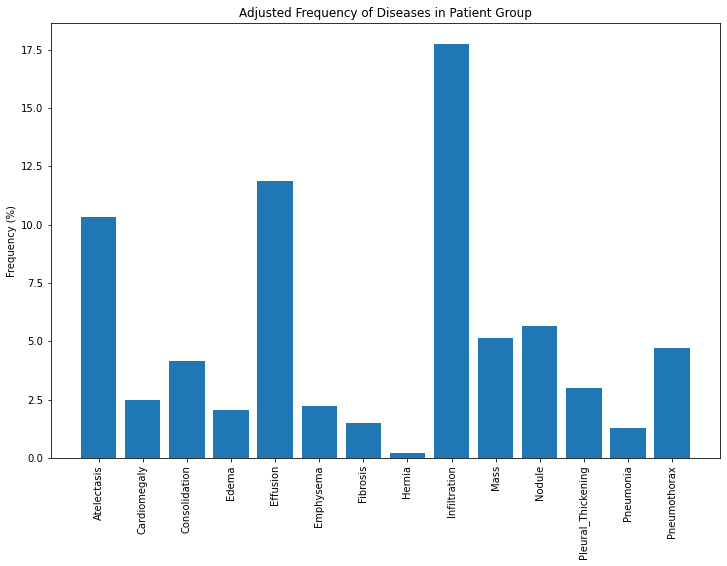

In [7]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')


In [8]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])


In [9]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])


C:\Users\GHOST\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


train 84090 validation 28030


In [10]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)


In [11]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)


In [12]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) 

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024))


Found 38819 validated image filenames belonging to 14 classes.
Found 12940 validated image filenames belonging to 14 classes.
Found 12940 validated image filenames belonging to 14 classes.


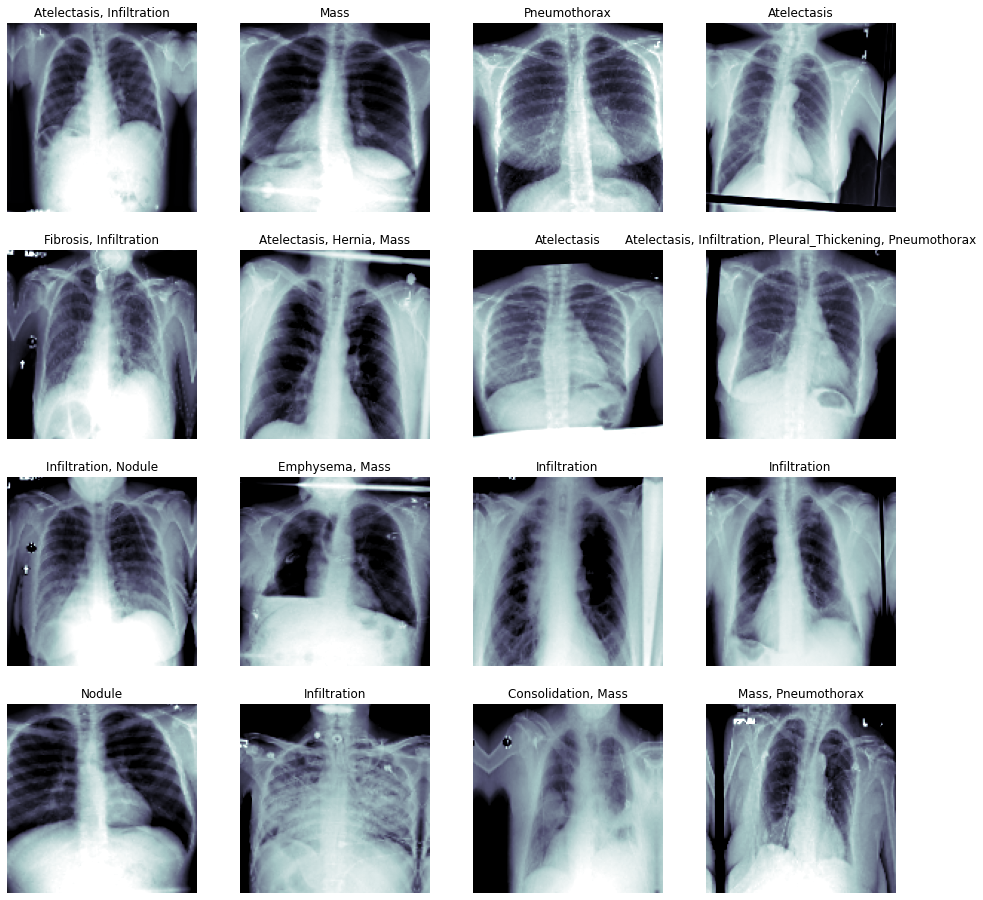

In [13]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')
    

In [14]:
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout


# Load the pretrained DenseNet model
base_densenet_model = DenseNet121(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Create the multi-disease model
model = Sequential()
model.add(base_densenet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(all_labels), activation='sigmoid'))


In [ ]:
model = DenseNet121(weights="D:/Xray_Data/data/small_data/nih/densenet.hdf5", include_top=False)
model = Model(inputs=model.input, outputs=Dense(len(all_labels), activation="sigmoid")(GlobalAveragePooling2D()(model.output)))
model.summary()


In [15]:
model.compile(optimizer='adam',  loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])


In [17]:
model.fit(train_gen, 
                                  steps_per_epoch=1000,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 10, 
                                  )


Epoch 1/10
1000/1000 [==============================] - 4015s 4s/step - loss: 0.2828 - binary_accuracy: 0.8914 - mae: 0.1676 - val_loss: 0.2925 - val_binary_accuracy: 0.8888 - val_mae: 0.1800
Epoch 2/10
1000/1000 [==============================] - 3935s 4s/step - loss: 0.2833 - binary_accuracy: 0.8913 - mae: 0.1678 - val_loss: 0.2897 - val_binary_accuracy: 0.8858 - val_mae: 0.1772
Epoch 3/10
1000/1000 [==============================] - 3938s 4s/step - loss: 0.2900 - binary_accuracy: 0.8891 - mae: 0.1720 - val_loss: 0.2950 - val_binary_accuracy: 0.8881 - val_mae: 0.1746
Epoch 4/10
1000/1000 [==============================] - 4450s 4s/step - loss: 0.2824 - binary_accuracy: 0.8916 - mae: 0.1673 - val_loss: 0.7218 - val_binary_accuracy: 0.8864 - val_mae: 0.1657
Epoch 5/10
1000/1000 [==============================] - 5233s 5s/step - loss: 0.2797 - binary_accuracy: 0.8921 - mae: 0.1658 - val_loss: 0.2929 - val_binary_accuracy: 0.8882 - val_mae: 0.1656
Epoch 6/10
1000/1000 [==================

In [18]:
model.save("D:/اخر_واحد_للورقه/Model.h5")
